In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [260]:
from sklearn import preprocessing
# for pca to fix colinearity 
from sklearn.decomposition import PCA

# checking olinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [182]:
#reading file

df= pd.read_csv('/Users/morgan/Desktop/SEIS 763 ML/ML_job_postings_finale_ready_v2.csv',header=0)
df.head()

,job_id,title,work_type,description,location,zip_code,min_salary,max_salary,normalized_salary,views,...,sector,city,state,name,latitude,longitude,gdp,income,region,moving_score
0,1014822088,Marketing Specialist,FULL_TIME,About TrackerTracker is a leading global cloud...,United States,NaN,70000.0,80000.0,75000.0,7.0,...,Information Technology,United States,US,Remote,NaN,NaN,483162.0,416325.0,Plains,50.000000
1,3189117072,Client Service Associate / Practice Manager,FULL_TIME,Company OverviewSignature Estate and Investmen...,"Redondo Beach, CA",90277.0,70000.0,100000.0,85000.0,6.0,...,Energy,Redondo Beach,CA,California,36.778261,-119.417932,3870379.0,3166135.0,Far West,4.214518
2,3260455681,Operations Specialist,FULL_TIME,Weyerhaeuser is searching for a Operations Spe...,"Castle Rock, WA",98611.0,72742.0,109113.0,90927.5,18.0,...,Materials,Castle Rock,WA,Washington,47.751074,-120.740139,807865.0,632296.0,Far West,4.703287
3,3277232283,HR & Administrative Assistant,FULL_TIME,HR & Administrative CoordinatorWork is Remote ...,United States,NaN,55000.0,72000.0,63500.0,59.0,...,Energy,United States,US,Remote,NaN,NaN,483162.0,416325.0,Plains,50.000000
4,3297645846,Contract Administrator,FULL_TIME,Contract AdministratorSummary of PositionThe C...,"Broomfield, CO",80020.0,74400.0,90000.0,82200.0,6.0,...,Materials,Broomfield,CO,Colorado,39.550051,-105.782067,529627.0,470606.0,Rocky Mountain,8.368978


In [11]:
df.columns

Index(['job_id', 'title', 'work_type', 'description', 'location', 'zip_code',
       'min_salary', 'max_salary', 'normalized_salary', 'views',
       'original_listed_time', 'expiry', 'day_posting', 'is_data_related',
       'formatted_experience_level', 'degree_level', 'job_classification',
       'soft_skills', 'programming_languages_score',
       'analysis_statistics_score', 'machine_learning_score',
       'data_visualization_score', 'cloud_platform_score', 'database_score',
       'big_data_tools_score', 'big_data_score', 'business_engineering_score',
       'company_id', 'company_name', 'company desc', 'company_size', 'country',
       'headquarter state', 'headquarter city', 'headquarter addr',
       'headquarter zipcode', 'industry', 'speciality', 'employee_count',
       'follower_count', 'sector', 'city', 'state', 'name', 'latitude',
       'longitude', 'gdp', 'income', 'region', 'moving_score'],
      dtype='object')

## LINEAR REGRESSION PART 1: Overview of the numerical variables

In [14]:
def fill_na_with_mean(df, columns):
  """
  Fills missing values in specified columns with their respective column means.

  Args:
    df: The DataFrame.
    columns: A list of column names to fill missing values.

  Returns:
    The DataFrame with missing values filled.
  """

  for col in columns:
    mean_value = df[col].mean()
    df[col].fillna(mean_value, inplace=True)

  return df

In [16]:
def apply_pca(df, columns, new_column_name):
    """
    Applies PCA to the specified columns and adds the first principal component to the DataFrame.

    Args:
        df: The DataFrame.
        columns: A list of column names to apply PCA to.
        new_column_name: The name of the new column to store the first principal component.

    Returns:
        The DataFrame with the added principal component.
    """

    pca = PCA(n_components=1)
    pca_result = pca.fit_transform(df[columns])
    df[new_column_name] = pca_result.flatten()
    df = df.drop(columns, axis=1)

    return df

In [18]:
def plot_histograms(df, columns, nrows=3, ncols=3, figsize=(15, 10)):
    """
    Plots histograms for the specified columns in a DataFrame.

    Args:
        df: The DataFrame containing the data.
        columns: A list of column names to plot.
        nrows: Number of rows in the subplot grid.
        ncols: Number of columns in the subplot grid.
        figsize: Figure size in inches.
    """

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(df[col], ax=axes[i], kde=True)
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [20]:
def remove_outliers_zscore_inplace(df, columns, threshold=3):
    """
    Removes outliers from a DataFrame based on z-scores, modifying the DataFrame in-place.

    Args:
        df: The DataFrame to process.
        columns: A list of column names to consider for outlier detection.
        threshold: The z-score threshold for identifying outliers.
    """

    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        df.drop(df[z_scores > threshold].index, inplace=True)

In [362]:
# Melt the DataFrame to a long format for easier plotting
# Select the columns of interest
def boxplot_check(df,columns):
    """
    Plot box-plot to identify outliers.

    Args:
        df: The DataFrame to process.
        columns: A list of column names to consider for ploting and outlier detection.

    Returns:
        boxplots
    """
    df_melted = df[columns].melt()
    
    # Create a boxplot
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='variable', y='value', data=df_melted)
    plt.title('Boxplot of Numerical Features')
    plt.xlabel('Feature')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.show()

In [24]:
def plot_scatter_plots(df, target_col, predictors):
    """
    Plots scatter plots of the target variable against each predictor variable.

    Args:
        df: The DataFrame containing the data.
        target_col: The name of the target column.
        predictors: A list of predictor column names.
    """

    num_plots = len(predictors)
    ncols = 3  # Number of columns in the subplot grid
    nrows = (num_plots - 1) // ncols + 1

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
    axes = axes.flatten()

    for i, predictor in enumerate(predictors):
        sns.scatterplot(x=target_col, y=predictor, data=df, ax=axes[i])
        axes[i].set_title(f'{target_col} vs {predictor}')

    plt.tight_layout()
    plt.show()

In [26]:
def check_collinearity(df):
    """
    Checks for collinearity in a DataFrame.

    Args:
        df: The DataFrame to check.

    Returns:
        None
    """

    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Visualize the correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    # Calculate VIF for each variable
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]

    print(vif_data)


In [184]:
apply_pca(df, ['income','gdp'], 'economic_score')

,job_id,title,work_type,description,location,zip_code,min_salary,max_salary,normalized_salary,views,...,follower_count,sector,city,state,name,latitude,longitude,region,moving_score,economic_score
0,1014822088,Marketing Specialist,FULL_TIME,About TrackerTracker is a leading global cloud...,United States,NaN,70000.0,80000.0,75000.0,7.0,...,5046,Information Technology,United States,US,Remote,NaN,NaN,Plains,50.000000,-1.283429e+06
1,3189117072,Client Service Associate / Practice Manager,FULL_TIME,Company OverviewSignature Estate and Investmen...,"Redondo Beach, CA",90277.0,70000.0,100000.0,85000.0,6.0,...,4650,Energy,Redondo Beach,CA,California,36.778261,-119.417932,Far West,4.214518,3.079390e+06
2,3260455681,Operations Specialist,FULL_TIME,Weyerhaeuser is searching for a Operations Spe...,"Castle Rock, WA",98611.0,72742.0,109113.0,90927.5,18.0,...,92381,Materials,Castle Rock,WA,Washington,47.751074,-120.740139,Far West,4.703287,-8.950336e+05
3,3277232283,HR & Administrative Assistant,FULL_TIME,HR & Administrative CoordinatorWork is Remote ...,United States,NaN,55000.0,72000.0,63500.0,59.0,...,1058,Energy,United States,US,Remote,NaN,NaN,Plains,50.000000,-1.283429e+06
4,3297645846,Contract Administrator,FULL_TIME,Contract AdministratorSummary of PositionThe C...,"Broomfield, CO",80020.0,74400.0,90000.0,82200.0,6.0,...,554,Materials,Broomfield,CO,Colorado,39.550051,-105.782067,Rocky Mountain,8.368978,-1.213210e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,3906260060,"Principal/Senior, Program Manager- Global Sale...",FULL_TIME,Your work days are brighter here.\n\nAt Workda...,"Chicago, IL",60601.0,140800.0,239300.0,190050.0,4.0,...,959754,Information Technology,Chicago,IL,Illinois,40.633125,-89.398528,Great Lakes,17.304814,-4.967535e+05
3898,3906260068,Senior Associate Quality Assurance Engineer,FULL_TIME,Your work days are brighter here.\n\nAt Workda...,"Atlanta, GA",30303.0,74500.0,151200.0,112850.0,4.0,...,959754,Information Technology,Atlanta,GA,Georgia,32.157435,-82.907123,Southeast,5.941396,-8.587215e+05
3899,3906260689,iOS Developer,FULL_TIME,VW. Two letters. Endless opportunities. A brig...,"Belmont, CA",94002.0,128400.0,190000.0,159200.0,5.0,...,3383,Information Technology,Belmont,CA,California,36.778261,-119.417932,Far West,4.214518,3.079390e+06
3900,3906262009,Senior Business Intelligence Developer,CONTRACT,Senior Business Intelligence DeveloperLos Ange...,"Los Angeles, CA",90001.0,133120.0,141440.0,137280.0,3.0,...,82090,Energy,Los Angeles,CA,California,36.778261,-119.417932,Far West,4.214518,3.079390e+06


In [186]:
apply_pca(df, ['employee_count','follower_count'], 'company_score')

,job_id,title,work_type,description,location,zip_code,min_salary,max_salary,normalized_salary,views,...,state,name,latitude,longitude,gdp,income,region,moving_score,economic_score,company_score
0,1014822088,Marketing Specialist,FULL_TIME,About TrackerTracker is a leading global cloud...,United States,NaN,70000.0,80000.0,75000.0,7.0,...,US,Remote,NaN,NaN,483162.0,416325.0,Plains,50.000000,-1.283429e+06,-1.807878e+06
1,3189117072,Client Service Associate / Practice Manager,FULL_TIME,Company OverviewSignature Estate and Investmen...,"Redondo Beach, CA",90277.0,70000.0,100000.0,85000.0,6.0,...,CA,California,36.778261,-119.417932,3870379.0,3166135.0,Far West,4.214518,3.079390e+06,-1.808273e+06
2,3260455681,Operations Specialist,FULL_TIME,Weyerhaeuser is searching for a Operations Spe...,"Castle Rock, WA",98611.0,72742.0,109113.0,90927.5,18.0,...,WA,Washington,47.751074,-120.740139,807865.0,632296.0,Far West,4.703287,-8.950336e+05,-1.720443e+06
3,3277232283,HR & Administrative Assistant,FULL_TIME,HR & Administrative CoordinatorWork is Remote ...,United States,NaN,55000.0,72000.0,63500.0,59.0,...,US,Remote,NaN,NaN,483162.0,416325.0,Plains,50.000000,-1.283429e+06,-1.811867e+06
4,3297645846,Contract Administrator,FULL_TIME,Contract AdministratorSummary of PositionThe C...,"Broomfield, CO",80020.0,74400.0,90000.0,82200.0,6.0,...,CO,Colorado,39.550051,-105.782067,529627.0,470606.0,Rocky Mountain,8.368978,-1.213210e+06,-1.812367e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,3906260060,"Principal/Senior, Program Manager- Global Sale...",FULL_TIME,Your work days are brighter here.\n\nAt Workda...,"Chicago, IL",60601.0,140800.0,239300.0,190050.0,4.0,...,IL,Illinois,40.633125,-89.398528,1098346.0,906648.0,Great Lakes,17.304814,-4.967535e+05,-8.529567e+05
3898,3906260068,Senior Associate Quality Assurance Engineer,FULL_TIME,Your work days are brighter here.\n\nAt Workda...,"Atlanta, GA",30303.0,74500.0,151200.0,112850.0,4.0,...,GA,Georgia,32.157435,-82.907123,831828.0,660447.0,Southeast,5.941396,-8.587215e+05,-8.529567e+05
3899,3906260689,iOS Developer,FULL_TIME,VW. Two letters. Endless opportunities. A brig...,"Belmont, CA",94002.0,128400.0,190000.0,159200.0,5.0,...,CA,California,36.778261,-119.417932,3870379.0,3166135.0,Far West,4.214518,3.079390e+06,-1.809539e+06
3900,3906262009,Senior Business Intelligence Developer,CONTRACT,Senior Business Intelligence DeveloperLos Ange...,"Los Angeles, CA",90001.0,133120.0,141440.0,137280.0,3.0,...,CA,California,36.778261,-119.417932,3870379.0,3166135.0,Far West,4.214518,3.079390e+06,-1.730832e+06


In [316]:
df.columns

Index(['job_id', 'title', 'work_type', 'description', 'location', 'zip_code',
       'min_salary', 'max_salary', 'normalized_salary', 'views',
       'original_listed_time', 'expiry', 'day_posting', 'is_data_related',
       'formatted_experience_level', 'degree_level', 'job_classification',
       'soft_skills', 'programming_languages_score',
       'analysis_statistics_score', 'machine_learning_score',
       'data_visualization_score', 'cloud_platform_score', 'database_score',
       'big_data_tools_score', 'big_data_score', 'business_engineering_score',
       'company_id', 'company_name', 'company desc', 'company_size', 'country',
       'headquarter state', 'headquarter city', 'headquarter addr',
       'headquarter zipcode', 'industry', 'speciality', 'employee_count',
       'follower_count', 'sector', 'city', 'state', 'name', 'latitude',
       'longitude', 'gdp', 'income', 'region', 'moving_score',
       'economic_score', 'company_score'],
      dtype='object')

In [408]:
#regression model using mostly numerical variables

clu_df=df[[ 'normalized_salary', 'views','day_posting',
       'formatted_experience_level', 'degree_level', 
       'company_size', 'sector', 'region', 'job_classification'
            ]]

clu_df['hardskill_score'] = df[['programming_languages_score',
                                 'analysis_statistics_score', 'machine_learning_score',
                                 'data_visualization_score', 'cloud_platform_score',
                                 'database_score', 'big_data_tools_score', 'big_data_score']].sum(axis=1)
clu_df['company_score']=df['company_score']
clu_df['economic_score']=df['economic_score']

/var/folders/fc/6wrgw2ln79dfcn7bb8qjd8v40000gn/T/ipykernel_41465/2014419058.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clu_df['hardskill_score'] = df[['programming_languages_score',
/var/folders/fc/6wrgw2ln79dfcn7bb8qjd8v40000gn/T/ipykernel_41465/2014419058.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clu_df['company_score']=df['company_score']
/var/folders/fc/6wrgw2ln79dfcn7bb8qjd8v40000gn/T/ipykernel_41465/2014419058.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [410]:
clu_df.columns

Index(['normalized_salary', 'views', 'day_posting',
       'formatted_experience_level', 'degree_level', 'company_size', 'sector',
       'region', 'job_classification', 'hardskill_score', 'company_score',
       'economic_score'],
      dtype='object')

In [412]:
clu_df.isnull().sum()

normalized_salary               0
views                          45
day_posting                     0
formatted_experience_level    973
degree_level                    0
company_size                   99
sector                          0
region                          0
job_classification              0
hardskill_score                 0
company_score                   0
economic_score                  0
dtype: int64

In [414]:
# 1st Standardization
# Select numerical columns to be standardized
numerical_cols = ['normalized_salary', 'views', 'day_posting',
       'company_size', 
       'hardskill_score', 'company_score', 'economic_score']
# Standardize numerical columns
scaled_data = preprocessing.scale(clu_df[numerical_cols])
scaled_df = pd.DataFrame(scaled_data, columns=numerical_cols,index = clu_df.index)

# Combine standardized numerical columns with categorical columns
categorical_cols = ['sector', 'region', 'formatted_experience_level',
                    'degree_level']


# One-hot encode all categorical columns except the first one
categorical_cols_encoded = pd.get_dummies(clu_df[categorical_cols], drop_first=True)

# Concatenate the original first categorical column with the encoded columns
categorical_cols_encoded = pd.concat([clu_df[categorical_cols].iloc[:, 0], categorical_cols_encoded], axis=1)

# Concatenate the numerical and categorical DataFrames
clu_df = pd.concat([scaled_df, categorical_cols_encoded], axis=1)



In [420]:

clu_df=clu_df.drop('sector',axis=1)
clu_df.columns

Index(['normalized_salary', 'views', 'day_posting', 'company_size',
       'hardskill_score', 'company_score', 'economic_score',
       'sector_Consumer Discretionary', 'sector_Consumer Staples',
       'sector_Energy', 'sector_Financials', 'sector_Health Care',
       'sector_Industrials', 'sector_Information Technology',
       'sector_Materials', 'sector_Real Estate', 'sector_Utilities',
       'region_Great Lakes ', 'region_Mideast ', 'region_New England ',
       'region_Plains', 'region_Plains ', 'region_Rocky Mountain ',
       'region_Southeast ', 'region_Southwest ',
       'formatted_experience_level_Director',
       'formatted_experience_level_Entry level',
       'formatted_experience_level_Executive',
       'formatted_experience_level_Internship',
       'formatted_experience_level_Mid-Senior level',
       'degree_level_bachelor, postgraduate', 'degree_level_postgraduate'],
      dtype='object')

In [422]:
fill_na_with_mean(clu_df, numerical_cols)

,normalized_salary,views,day_posting,company_size,hardskill_score,company_score,economic_score,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,...,region_Rocky Mountain,region_Southeast,region_Southwest,formatted_experience_level_Director,formatted_experience_level_Entry level,formatted_experience_level_Executive,formatted_experience_level_Internship,formatted_experience_level_Mid-Senior level,"degree_level_bachelor, postgraduate",degree_level_postgraduate
0,-0.043544,-0.215448,-0.259610,-1.633884e+00,-0.618285,-0.318000,-0.766226,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.037447,-0.228575,-0.259610,-1.633884e+00,-0.271605,-0.318070,1.838441,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,-0.033832,-0.071046,4.231212,8.783103e-01,-0.271605,-0.302621,-0.534348,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.050556,0.467181,-0.259610,-2.540989e-16,0.075076,-0.318702,-0.766226,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,-0.039154,-0.228575,4.231212,-1.265676e-01,-0.271605,-0.318790,-0.724304,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,0.026608,-0.254830,-0.259610,8.783103e-01,-0.964965,-0.150033,-0.296569,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3898,-0.020465,-0.254830,-0.259610,8.783103e-01,0.768436,-0.150033,-0.512669,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3899,0.007797,-0.241703,-0.259610,-1.131445e+00,0.075076,-0.318292,1.838441,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3900,-0.005569,-0.267958,-0.259610,-1.265676e-01,1.808477,-0.304448,1.838441,False,False,True,...,False,False,False,False,False,False,False,True,False,False


In [424]:
#reg_df.isnull().sum()
#target_df.dtypes

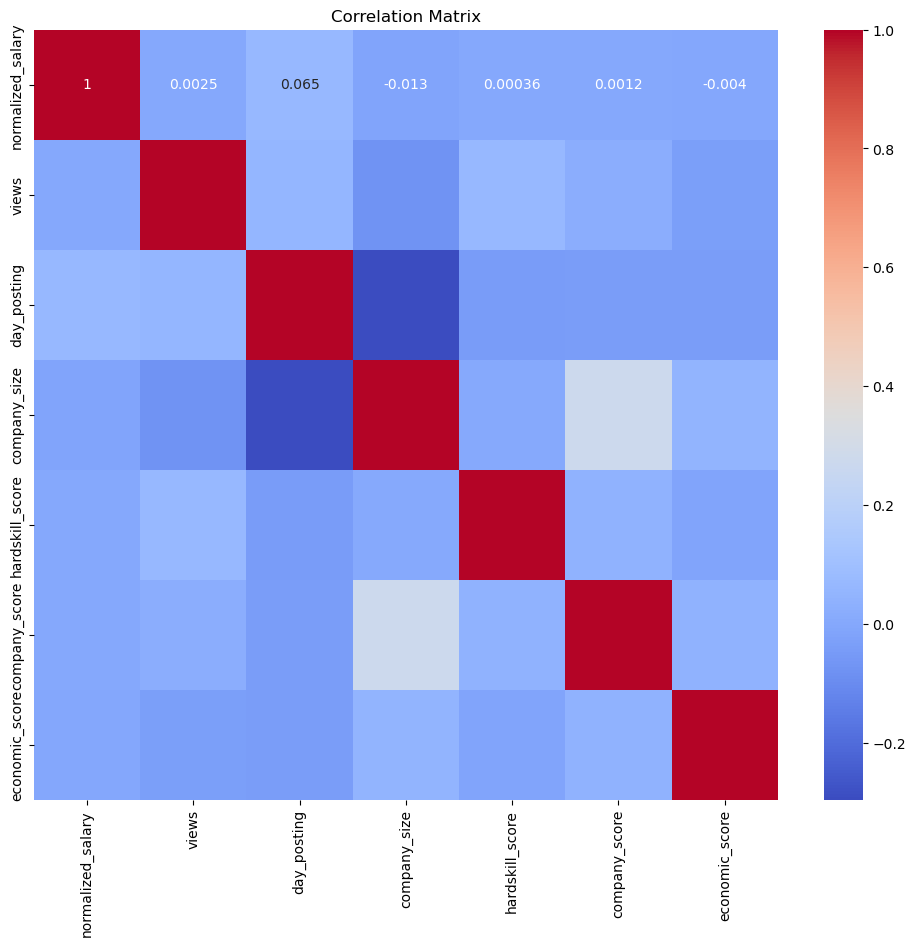

             feature       VIF
0  normalized_salary  1.004252
1              views  1.014414
2        day_posting  1.107471
3       company_size  1.191163
4    hardskill_score  1.008725
5      company_score  1.087623
6     economic_score  1.004807


In [426]:
check_collinearity(clu_df[numerical_cols])

In [428]:

outliers_checkingn_cols = ['views', 'company_size',  'hardskill_score',
                  'company_score', 'economic_score','normalized_salary']
remove_outliers_zscore_inplace(clu_df,outliers_checkingn_cols, threshold=3)

In [430]:
clu_df

,normalized_salary,views,day_posting,company_size,hardskill_score,company_score,economic_score,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,...,region_Rocky Mountain,region_Southeast,region_Southwest,formatted_experience_level_Director,formatted_experience_level_Entry level,formatted_experience_level_Executive,formatted_experience_level_Internship,formatted_experience_level_Mid-Senior level,"degree_level_bachelor, postgraduate",degree_level_postgraduate
0,-0.043544,-0.215448,-0.259610,-1.633884e+00,-0.618285,-0.318000,-0.766226,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.037447,-0.228575,-0.259610,-1.633884e+00,-0.271605,-0.318070,1.838441,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,-0.033832,-0.071046,4.231212,8.783103e-01,-0.271605,-0.302621,-0.534348,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.050556,0.467181,-0.259610,-2.540989e-16,0.075076,-0.318702,-0.766226,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,-0.039154,-0.228575,4.231212,-1.265676e-01,-0.271605,-0.318790,-0.724304,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,0.026608,-0.254830,-0.259610,8.783103e-01,-0.964965,-0.150033,-0.296569,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3898,-0.020465,-0.254830,-0.259610,8.783103e-01,0.768436,-0.150033,-0.512669,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3899,0.007797,-0.241703,-0.259610,-1.131445e+00,0.075076,-0.318292,1.838441,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3900,-0.005569,-0.267958,-0.259610,-1.265676e-01,1.808477,-0.304448,1.838441,False,False,True,...,False,False,False,False,False,False,False,True,False,False


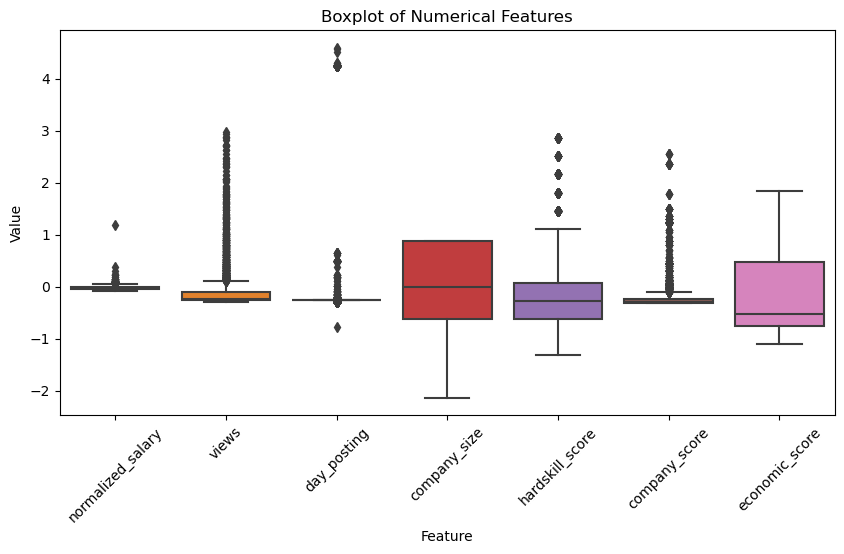

In [432]:
boxplot_check(clu_df,numerical_cols) 

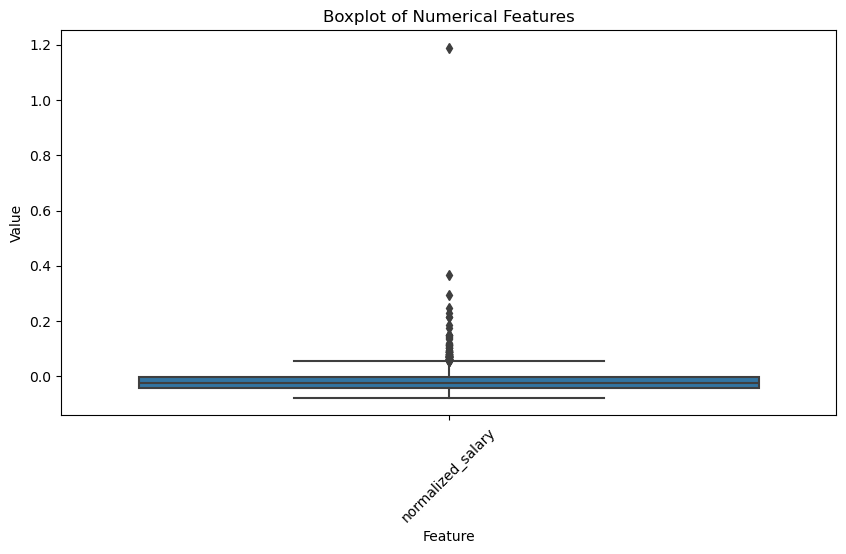

In [434]:
boxplot_check(clu_df,['normalized_salary'])

## DT PAR2: Clustering

In [512]:
clu_df.columns

Index(['normalized_salary', 'views', 'day_posting', 'company_size',
       'hardskill_score', 'company_score', 'economic_score',
       'sector_Consumer Discretionary', 'sector_Consumer Staples',
       'sector_Energy', 'sector_Financials', 'sector_Health Care',
       'sector_Industrials', 'sector_Information Technology',
       'sector_Materials', 'sector_Real Estate', 'sector_Utilities',
       'region_Great Lakes ', 'region_Mideast ', 'region_New England ',
       'region_Plains', 'region_Plains ', 'region_Rocky Mountain ',
       'region_Southeast ', 'region_Southwest ',
       'formatted_experience_level_Director',
       'formatted_experience_level_Entry level',
       'formatted_experience_level_Executive',
       'formatted_experience_level_Internship',
       'formatted_experience_level_Mid-Senior level',
       'degree_level_bachelor, postgraduate', 'degree_level_postgraduate'],
      dtype='object')

In [514]:
# standardization

clu_scaled=preprocessing.scale(clu_df)

In [528]:
# Convert clu_scaled back to DataFrame
clu_scaled_df = pd.DataFrame(clu_scaled, columns=clu_df.columns)

In [540]:
Single = AgglomerativeClustering(metric='euclidean', n_clusters=5, linkage='single')
Single.fit(clu_scaled_df)
#print(Single.labels_)

Z_Single = linkage(clu_scaled_df, method='single')

In [542]:
Complete = AgglomerativeClustering(metric='euclidean', n_clusters=5, linkage='complete')
Complete.fit(clu_scaled_df)
#print(Complete.labels_)

Z_Complete = linkage(clu_scaled_df, method='complete')

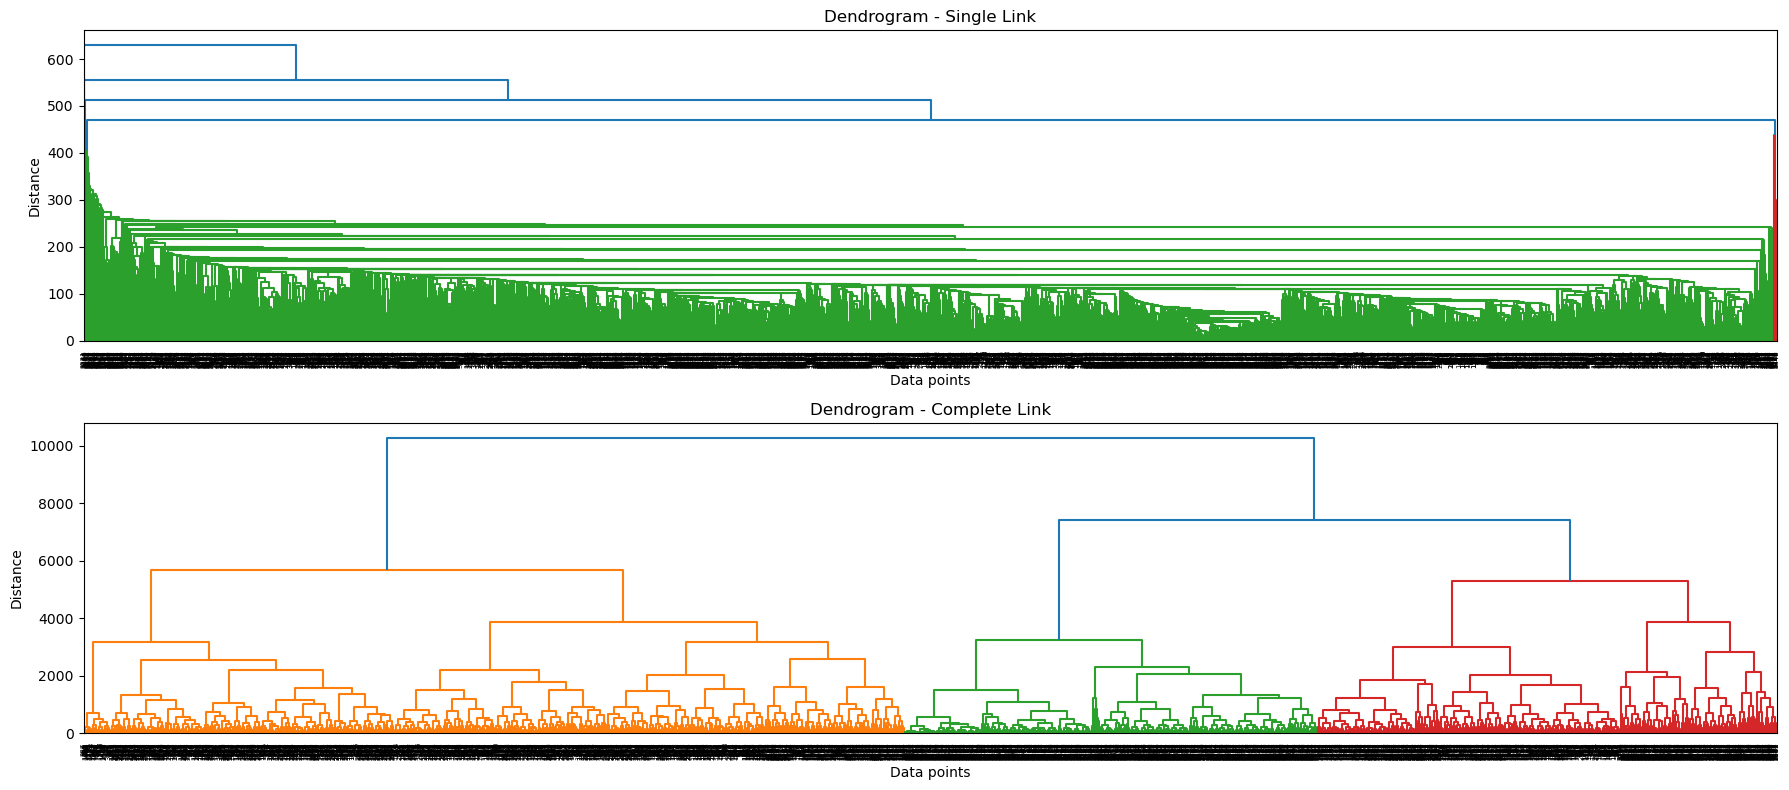

In [534]:
# Create the figure and axes for subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 8))

# Plot the dendrogram on both subplots
dendrogram(Z_Single, ax=axes[0])
dendrogram(Z_Complete, ax=axes[1])

# Set titles and labels for subplots
axes[0].set_title('Dendrogram - Single Link')
axes[0].set_xlabel('Data points')
axes[0].set_ylabel('Distance')

axes[1].set_title('Dendrogram - Complete Link')
axes[1].set_xlabel('Data points')
axes[1].set_ylabel('Distance')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

In [576]:
from scipy.cluster.hierarchy import fcluster

# Cut the linkage into clusters using a distance threshold
distance_threshold = 33
cluster_labels = fcluster(Z_Complete, t=distance_threshold, criterion='distance')
unique_labels = np.unique(cluster_labels)
print(unique_labels)
print(cluster_labels.shape)

[1 2 3 4 5]
(3645,)


## Clustering with pca (REDUCTION OF DIMENTIONS)

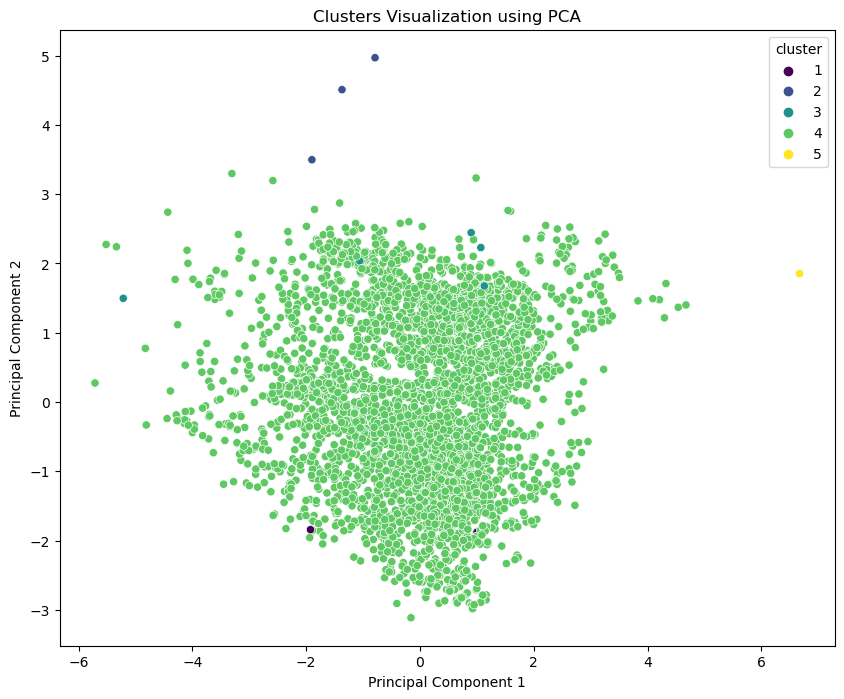

In [578]:
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_result = pca.fit_transform(clu_scaled)

# Create a new DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['cluster'] = cluster_labels

# Visualize clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis')
plt.title('Clusters Visualization using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [473]:
# Create the custom colormap
from matplotlib.colors import ListedColormap
#colors = ['red', 'green', 'blue', 'orange', 'yellow']
#cmap = ListedColormap(colors)

ValueError: x and y must be the same size

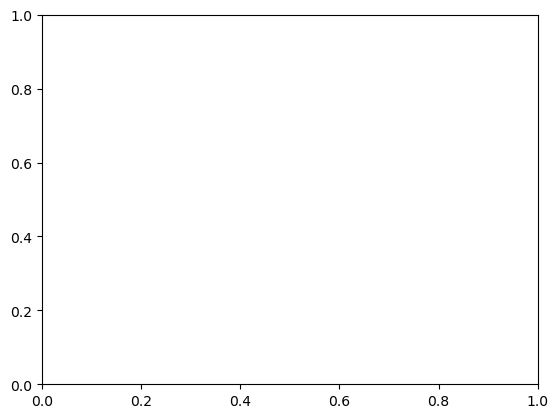

In [580]:
plt.scatter(clu_scaled[1:, 0], clu_scaled[1:,1:], c=cluster_labels, cmap=cmap)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Clustering with Complete Link, Cut Threshold = 500)')

legend_handles = [plt.Line2D([], [], marker='o', color=color, linestyle='None') for color in colors]
legend_labels = colors

# Create the legend
plt.legend(legend_handles, legend_labels)

plt.show()

NameError: name 'python' is not defined